<a href="https://colab.research.google.com/github/CHERR4/M07-Visualizacion-Datos/blob/main/SeminarioVisualizacionEconomia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Jose Ramón Casero Fuentes


# Seminario visualización
## Código adicional


## Instalación de paquetes requeridos
En este apartado instalamos algunos de los paquetes necesarios para obtener y procesar los datos.

In [1]:
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install shapely==1.6.3
!pip install plotly-geo
!pip install pycountry

     |████████████████████████████████| 890kB 6.4MB/s 
     |████████████████████████████████| 6.5MB 12.4MB/s 
     |████████████████████████████████| 15.3MB 284kB/s 
     |████████████████████████████████| 184kB 4.8MB/s 
  Created wheel for pyshp: filename=pyshp-1.2.10-cp37-none-any.whl size=20468 sha256=296e4095f3e5d9b4029c5c81f0632dfcdb7c8e0525aae973886877304f91270a
  Stored in directory: /root/.cache/pip/wheels/ba/1a/67/6a12977f362c33a15edc753daf92c6f01879dbf4db76faf0dd
Successfully built pyshp
     |████████████████████████████████| 225kB 4.8MB/s 
  Created wheel for shapely: filename=Shapely-1.6.3-cp37-cp37m-linux_x86_64.whl size=635629 sha256=f9e5ce90aa88e12215f8b916155112b8d6f3d2028a73c9c410b88c212a8720fb
  Stored in directory: /root/.cache/pip/wheels/12/87/ca/56f7f9f986d5041c31b61bd01fc14f16675c4123c1f073750c
Successfully built shapely
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing install

## API WorldBank
Vamos a consultar la api del banco mundial para obtener los datos económicos de todos los países que dispone.

In [128]:
import requests
import pandas as pd

economic_data_url = "http://api.worldbank.org/v2/country?format=json&per_page=300"

economic_data_request = requests.get(economic_data_url)
economic_data = pd.DataFrame(economic_data_request.json()[1])
economic_data.head()

,id,iso2Code,name,region,adminregion,incomeLevel,lendingType,capitalCity,longitude,latitude
0,ABW,AW,Aruba,"{'id': 'LCN', 'iso2code': 'ZJ', 'value': 'Lati...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'HIC', 'iso2code': 'XD', 'value': 'High...","{'id': 'LNX', 'iso2code': 'XX', 'value': 'Not ...",Oranjestad,-70.0167,12.5167
1,AFG,AF,Afghanistan,"{'id': 'SAS', 'iso2code': '8S', 'value': 'Sout...","{'id': 'SAS', 'iso2code': '8S', 'value': 'Sout...","{'id': 'LIC', 'iso2code': 'XM', 'value': 'Low ...","{'id': 'IDX', 'iso2code': 'XI', 'value': 'IDA'}",Kabul,69.1761,34.5228
2,AFR,A9,Africa,"{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': ''}","{'id': 'NA', 'iso2code': 'NA', 'value': 'Aggre...","{'id': '', 'iso2code': '', 'value': 'Aggregates'}",,,
3,AGO,AO,Angola,"{'id': 'SSF', 'iso2code': 'ZG', 'value': 'Sub-...","{'id': 'SSA', 'iso2code': 'ZF', 'value': 'Sub-...","{'id': 'LMC', 'iso2code': 'XN', 'value': 'Lowe...","{'id': 'IBD', 'iso2code': 'XF', 'value': 'IBRD'}",Luanda,13.242,-8.81155
4,ALB,AL,Albania,"{'id': 'ECS', 'iso2code': 'Z7', 'value': 'Euro...","{'id': 'ECA', 'iso2code': '7E', 'value': 'Euro...","{'id': 'UMC', 'iso2code': 'XT', 'value': 'Uppe...","{'id': 'IBD', 'iso2code': 'XF', 'value': 'IBRD'}",Tirane,19.8172,41.3317


## Formateo datos
Modificamos los datos para facilitar la posterior visualización, por ejemplo en la columna del nivel de ganancia (incomeLevel) vamos a quedarnos con lo que nos interesa, el valor de ganancia y desechamos el isocode etc.
Además eliminamos aquellas columnas que no pensamos usar en la visualización: "region", "adminregion", "lendingType".
Finalmente vamos a eliminar las regiones donde su "incomeLevel" es 'Agregates' porque eso indica que es un conjunto de regiones, por ejemplo África seria un conjunto de todas las regiones que la componen.

In [129]:
def income_transale(income):
  translator = {
      'High income': 'Ingresos altos',
      'Upper middle income': 'Ingresos medio-altos',
      'Lower middle income': 'Ingresos medio-bajos',
      'Low income': 'Ingresos bajos',
      'Aggregates': 'Agregado'
  }
  return translator[income]

economic_data['ingreso'] = economic_data.apply(lambda row: income_transale(row['incomeLevel']['value']), axis= 1)
economic_data.drop(['region', 'adminregion', 'lendingType', 'incomeLevel'], axis=1, inplace=True)
economic_data.drop(economic_data[economic_data['ingreso'] == 'Agregado'].index, inplace=True)


In [130]:
economic_data

,id,iso2Code,name,capitalCity,longitude,latitude,ingreso
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,Ingresos altos
1,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,Ingresos bajos
3,AGO,AO,Angola,Luanda,13.242,-8.81155,Ingresos medio-bajos
4,ALB,AL,Albania,Tirane,19.8172,41.3317,Ingresos medio-altos
5,AND,AD,Andorra,Andorra la Vella,1.5218,42.5075,Ingresos altos
...,...,...,...,...,...,...,...
291,XKX,XK,Kosovo,Pristina,20.926,42.565,Ingresos medio-altos
293,YEM,YE,"Yemen, Rep.",Sana'a,44.2075,15.352,Ingresos bajos
294,ZAF,ZA,South Africa,Pretoria,28.1871,-25.746,Ingresos medio-altos
295,ZMB,ZM,Zambia,Lusaka,28.2937,-15.3982,Ingresos medio-bajos


## Guardar para primera visualización
Para la primera visualización que vamos a realizar con **DataWrapper**, nos interesan el **id** de la región y el el **incomeLevel**, de esta manera vamos a ver en el mapa cada región con el color de su categoría. 
Guardo el dataset para importarlo en DataWrapper.

In [5]:
economic_data.to_csv('economic_data_by_country.csv')

## Temp 
Como el objetivo del trabajo es visualizar la relación entre la temperatura y la capacidad económicas del país, tenemos esta función **get_80s_temp_country**, capaz de obtener la temperatura media entre los años 80s y 90s de cada país.

In [131]:
def get_80s_temp_country(iso3country):
  try:
    basic_url = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/annualavg/tas/1980/1999/'
    url = basic_url + iso3country
    temp_request = requests.get(url)
    temp_df = pd.DataFrame(temp_request.json())
    temp_df['temp'] = temp_df.apply(lambda row: row['annualData'][0], axis= 1)
    return temp_df['temp'].mean()
  except:
    return 0



economic_data['temp'] = economic_data.apply(lambda row: get_80s_temp_country(row['id']), axis= 1)
economic_data.head()

,id,iso2Code,name,capitalCity,longitude,latitude,ingreso,temp
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,Ingresos altos,25.452445
1,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,Ingresos bajos,10.457171
3,AGO,AO,Angola,Luanda,13.242,-8.81155,Ingresos medio-bajos,22.626803
4,ALB,AL,Albania,Tirane,19.8172,41.3317,Ingresos medio-altos,13.328044
5,AND,AD,Andorra,Andorra la Vella,1.5218,42.5075,Ingresos altos,13.869031


## Precipitation
Vamos a obtener además otras variables climáticas como las precipitaciones para ver la correlación entre estas y la situación económica. 

In [132]:
def get_80s_prep_country(iso3country):
  try:
    basic_url = 'http://climatedataapi.worldbank.org/climateweb/rest/v1/country/annualavg/pr/1980/1999/'
    url = basic_url + iso3country
    prep_request = requests.get(url)
    prep_df = pd.DataFrame(prep_request.json())
    prep_df['prep'] = prep_df.apply(lambda row: row['annualData'][0], axis= 1)
    return prep_df['prep'].mean()
  except:
    return 0

economic_data['prep'] = economic_data.apply(lambda row: get_80s_prep_country(row['id']), axis= 1)
economic_data.head()

,id,iso2Code,name,capitalCity,longitude,latitude,ingreso,temp,prep
0,ABW,AW,Aruba,Oranjestad,-70.0167,12.5167,Ingresos altos,25.452445,530.634375
1,AFG,AF,Afghanistan,Kabul,69.1761,34.5228,Ingresos bajos,10.457171,353.900578
3,AGO,AO,Angola,Luanda,13.242,-8.81155,Ingresos medio-bajos,22.626803,1073.296514
4,ALB,AL,Albania,Tirane,19.8172,41.3317,Ingresos medio-altos,13.328044,686.546533
5,AND,AD,Andorra,Andorra la Vella,1.5218,42.5075,Ingresos altos,13.869031,540.619647


## Guardamos dataset
Con estas nuevas variables, vamos a visualizar el mapa de temperaturas y precipitaciones global. Con esto  podemos ver la similitud ente las escalas de los colores en los mapas.

In [8]:
economic_data.to_csv('climatic_economic_data_by_country.csv')

## Análisis de las distribuciones


In [133]:
economic_data['quantile_temp'] = pd.qcut(economic_data['temp'], 4, labels=False)
economic_data['quantile_prep'] = pd.qcut(economic_data['prep'], 4, labels=False)

## Distribucione: Income-Temp Income-Prep

Text(0, 0.5, 'densidad')

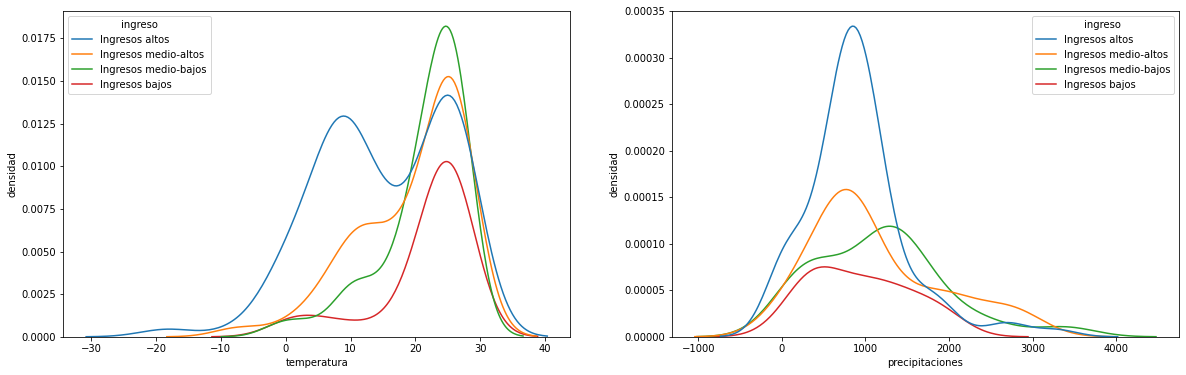

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns


fig, ax = plt.subplots(1, 2, figsize=(20, 6))
distribution_kde = sns.kdeplot(ax=ax[0],x="temp", hue="ingreso", data=economic_data)
distribution_kde.set_xlabel('temperatura')
distribution_kde.set_ylabel('densidad')

distribution_kde = sns.kdeplot(ax=ax[1],x="prep", hue="ingreso", data=economic_data)
distribution_kde.set_xlabel('precipitaciones')
distribution_kde.set_ylabel('densidad')

## Distribuciones en barras: Income-Temp Income-Prep

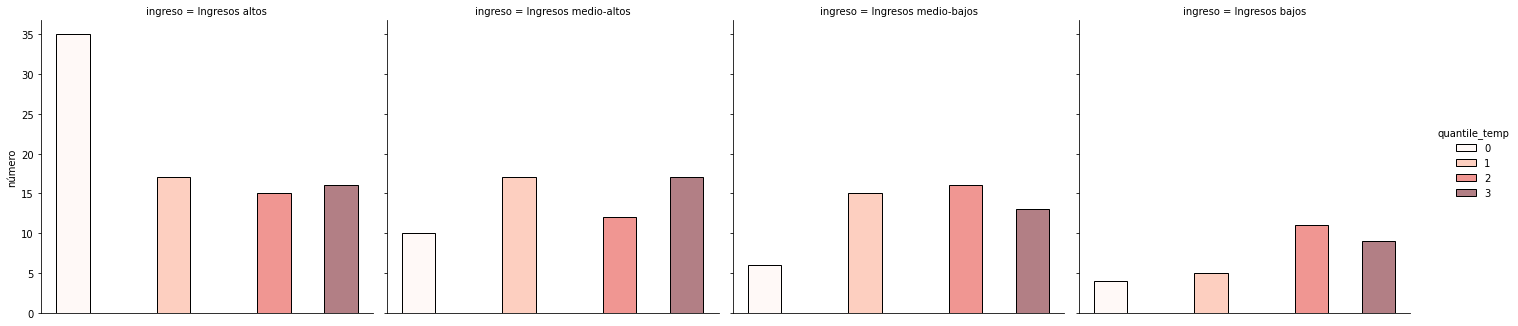

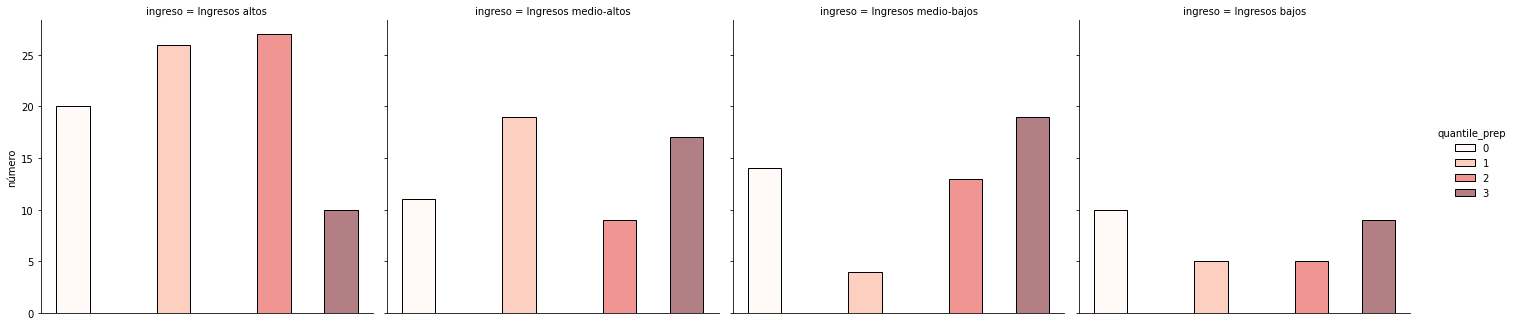

In [141]:
col_order = ['Ingresos altos', 'Ingresos medio-altos', 'Ingresos medio-bajos', 'Ingresos bajos']
quantile_income_plot = sns.displot(x="quantile_temp", hue="quantile_temp", col="ingreso", palette="Reds", col_order=col_order, data=economic_data)
quantile_income_plot.set(xticks=[])
quantile_income_plot.set_axis_labels('', 'número')
quantile_income_plot = sns.displot(x="quantile_prep", hue="quantile_prep", col="ingreso", palette="Reds", col_order=col_order, data=economic_data)
quantile_income_plot.set(xticks=[])
quantile_income_plot.set_axis_labels('', 'número')

## Distribuciones en barras: Temp-Income Prep-Income

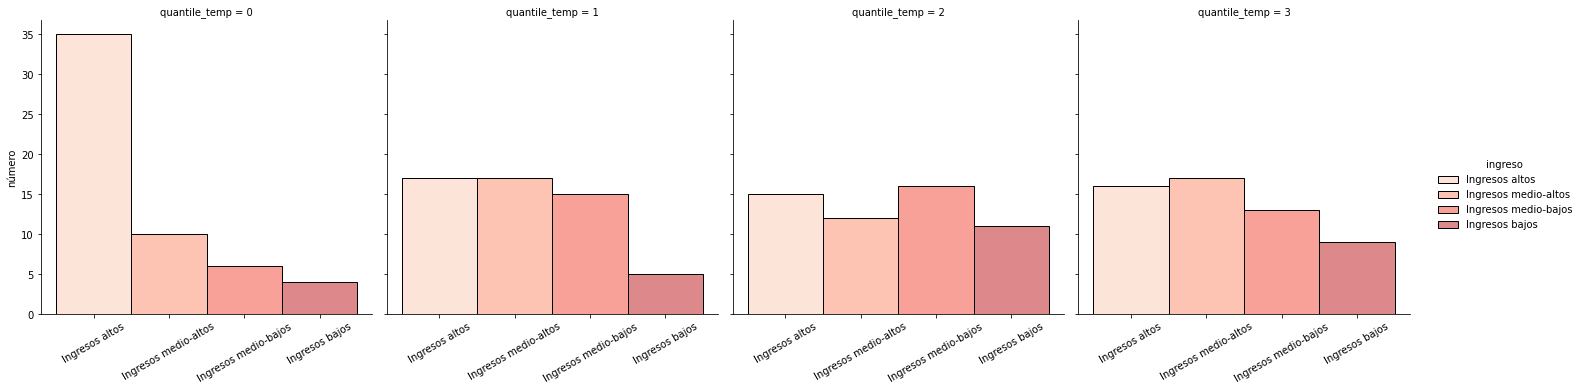

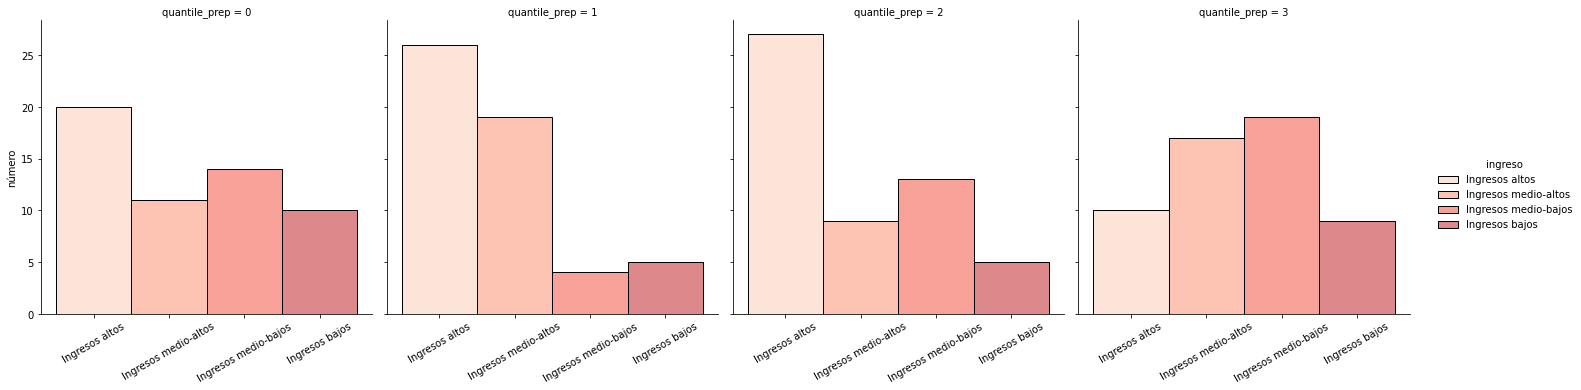

In [142]:
economic_data['ingreso'] = pd.Categorical(economic_data['ingreso'],
                                   categories=col_order,
                                   ordered=True)
income_quantile_temp_plot = sns.displot(x="ingreso", hue="ingreso", col="quantile_temp", palette="Reds", hue_order=col_order,  data=economic_data)
income_quantile_temp_plot.set_xticklabels(rotation=30)
income_quantile_temp_plot.set_axis_labels('', 'número')
income_quantile_prep_plot = sns.displot(x="ingreso", hue="ingreso", col="quantile_prep", palette="Reds", hue_order=col_order,  data=economic_data)
income_quantile_prep_plot.set_xticklabels(rotation=30)
income_quantile_prep_plot.set_axis_labels('', 'número')

## Web scrapping Wikipedia
En este apartado vamos a realizar web scrapping en Wikipedia para obtener datos más específicos del PIB per cápita, el cuál es un buen índice de riqueza de un país. Para esto vamos a utilizar **BeautifulSoup** y **requests**.

In [90]:
from bs4 import BeautifulSoup

pib_per_cap_wiki = "https://es.wikipedia.org/wiki/Anexo:Pa%C3%ADses_por_PIB_(nominal)_per_c%C3%A1pita"
pib_per_cap_wiki_en = "https://en.wikipedia.org/wiki/List_of_countries_by_GDP_(nominal)_per_capita"
pib_request = requests.get(pib_per_cap_wiki_en)

soup = BeautifulSoup(pib_request.text, 'lxml')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of countries by GDP (nominal) per capita - Wikipedia
  </title>
  <script>
   document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgRequestId":"15aa659a-6b08-4fdb-b2eb-0479a59ef578","wgCSPNonce":!1,"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_countries_by_GDP_(nominal)_per_capita","wgTitle":"List of countries by GDP (nominal) per capita","wgCurRevisionId":1019612562,"wgRevisionId":1019612562,"wgArticleId":1050736,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["Wikipedia indefinitely semi-protected pages","Article

In [14]:
table_name = "wikitable sortable"

fmi_table = soup.find('table', {'class': table_name})
fmi_table

<table class="wikitable sortable" style="margin-left:auto;margin-right:auto;text-align: left">
<tbody><tr>
<th data-sort-type="number">Rank
</th>
<th>Country/Territory
</th>
<th><a href="/wiki/United_States_dollar" title="United States dollar">US$</a>
</th></tr>
<tr>
<td align="right">1</td>
<td><span class="flagicon"><img alt="" class="thumbborder" data-file-height="600" data-file-width="1000" decoding="async" height="14" src="//upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/23px-Flag_of_Luxembourg.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/35px-Flag_of_Luxembourg.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/46px-Flag_of_Luxembourg.svg.png 2x" width="23"/> </span><a href="/wiki/Luxembourg" title="Luxembourg">Luxembourg</a></td>
<td align="right">131,782
</td></tr>
<tr>
<td align="right">2</td>
<td><span class="flagicon"><img alt="" class="thumbborder" data-file-height

In [15]:
rows = fmi_table.findAll('td')
rows

[<td align="right">1</td>,
 <td><span class="flagicon"><img alt="" class="thumbborder" data-file-height="600" data-file-width="1000" decoding="async" height="14" src="//upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/23px-Flag_of_Luxembourg.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/35px-Flag_of_Luxembourg.svg.png 1.5x, //upload.wikimedia.org/wikipedia/commons/thumb/d/da/Flag_of_Luxembourg.svg/46px-Flag_of_Luxembourg.svg.png 2x" width="23"/> </span><a href="/wiki/Luxembourg" title="Luxembourg">Luxembourg</a></td>,
 <td align="right">131,782
 </td>,
 <td align="right">2</td>,
 <td><span class="flagicon"><img alt="" class="thumbborder" data-file-height="512" data-file-width="512" decoding="async" height="16" src="//upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Flag_of_Switzerland.svg/16px-Flag_of_Switzerland.svg.png" srcset="//upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Flag_of_Switzerland.svg/24px-Flag_o

## Limpieza características
Obtenemos algunas características que no queremos como la posición en el ranking del PIBxC, ya que deriva de la variables PIBxC. Además hay algún error en el formato de los nombres y los variable PIB que voy a solucionar

In [16]:
import re

def format_country_name_or_pib(country_name_or_pib):
  country_name_or_pib = re.sub('\xa0', ' ', country_name_or_pib)
  country_name_or_pib = re.sub('\n', '', country_name_or_pib)
  country_name_or_pib = country_name_or_pib.strip()
  country_name_or_pib = re.sub(',', '', country_name_or_pib)
  return country_name_or_pib

country_pib_perc = [format_country_name_or_pib(x.text) for ind, x in enumerate(rows) if ind % 3 != 0]
country_pib_perc

['Luxembourg',
 '131782',
 'Switzerland',
 '94696',
 'Ireland',
 '94556',
 'Norway',
 '81995',
 'United States',
 '68309',
 'Denmark',
 '67218',
 'Iceland',
 '65273',
 'Singapore',
 '64103',
 'Australia',
 '62723',
 'Qatar',
 '59143',
 'Sweden',
 '58977',
 'Macau',
 '58004',
 'Netherlands',
 '58003',
 'Finland',
 '54330',
 'Austria',
 '53859',
 'Germany',
 '51860',
 'Belgium',
 '50103',
 'San Marino',
 '49765',
 'Canada',
 '49222',
 'Hong Kong',
 '49036',
 'Israel',
 '47602',
 'New Zealand',
 '47499',
 'United Kingdom',
 '46344',
 'France',
 '44995',
 'Japan',
 '42928',
 'United Arab Emirates',
 '35171',
 'Italy',
 '34997',
 'South Korea',
 '34866',
 'Brunei',
 '33097',
 'Puerto Rico',
 '32233',
 'Taiwan',
 '32123',
 'Malta',
 '31576',
 'Spain',
 '30996',
 'Bahamas',
 '30070',
 'Cyprus',
 '29551',
 'Slovenia',
 '28104',
 'Estonia',
 '26470',
 'Czech Republic',
 '25732',
 'Kuwait',
 '25290',
 'Portugal',
 '25065',
 'Bahrain',
 '24294',
 'Aruba',
 '22852',
 'Saudi Arabia',
 '22700',
 'Li

In [17]:
def remove_duplicate(name):
  name_without_repeat_arr = []
  splited_name = name.split(' ')
  for part in splited_name:
    if (part not in name_without_repeat_arr) or (splited_name.count(part) == 1):
      name_without_repeat_arr.append(part)

  name_no_repeat = ' '.join(name_without_repeat_arr)
  print(name_no_repeat)
  return name_no_repeat

country_pib_perc_no_repeat = [remove_duplicate(x) for x in country_pib_perc]
country_pib_perc_no_repeat

Luxembourg
131782
Switzerland
94696
Ireland
94556
Norway
81995
United States
68309
Denmark
67218
Iceland
65273
Singapore
64103
Australia
62723
Qatar
59143
Sweden
58977
Macau
58004
Netherlands
58003
Finland
54330
Austria
53859
Germany
51860
Belgium
50103
San Marino
49765
Canada
49222
Hong Kong
49036
Israel
47602
New Zealand
47499
United Kingdom
46344
France
44995
Japan
42928
United Arab Emirates
35171
Italy
34997
South Korea
34866
Brunei
33097
Puerto Rico
32233
Taiwan
32123
Malta
31576
Spain
30996
Bahamas
30070
Cyprus
29551
Slovenia
28104
Estonia
26470
Czech Republic
25732
Kuwait
25290
Portugal
25065
Bahrain
24294
Aruba
22852
Saudi Arabia
22700
Lithuania
22245
Slovakia
21529
Latvia
19824
Greece
19673
Hungary
18075
Poland
16930
Croatia
16247
Oman
16212
Barbados
16036
Trinidad and Tobago
15752
Uruguay
15653
Chile
15617
Romania
14968
Saint Kitts and Nevis
14402
Antigua and Barbuda
13824
Panama
13690
Palau
12850
China
11819
Costa Rica
11806
Maldives
11801
Russia
11654
Malaysia
11604
Bulgari

['Luxembourg',
 '131782',
 'Switzerland',
 '94696',
 'Ireland',
 '94556',
 'Norway',
 '81995',
 'United States',
 '68309',
 'Denmark',
 '67218',
 'Iceland',
 '65273',
 'Singapore',
 '64103',
 'Australia',
 '62723',
 'Qatar',
 '59143',
 'Sweden',
 '58977',
 'Macau',
 '58004',
 'Netherlands',
 '58003',
 'Finland',
 '54330',
 'Austria',
 '53859',
 'Germany',
 '51860',
 'Belgium',
 '50103',
 'San Marino',
 '49765',
 'Canada',
 '49222',
 'Hong Kong',
 '49036',
 'Israel',
 '47602',
 'New Zealand',
 '47499',
 'United Kingdom',
 '46344',
 'France',
 '44995',
 'Japan',
 '42928',
 'United Arab Emirates',
 '35171',
 'Italy',
 '34997',
 'South Korea',
 '34866',
 'Brunei',
 '33097',
 'Puerto Rico',
 '32233',
 'Taiwan',
 '32123',
 'Malta',
 '31576',
 'Spain',
 '30996',
 'Bahamas',
 '30070',
 'Cyprus',
 '29551',
 'Slovenia',
 '28104',
 'Estonia',
 '26470',
 'Czech Republic',
 '25732',
 'Kuwait',
 '25290',
 'Portugal',
 '25065',
 'Bahrain',
 '24294',
 'Aruba',
 '22852',
 'Saudi Arabia',
 '22700',
 'Li

## Dataframe
Creo un dataframe de pandas con los datos anteriores que nos va a permitir un mayor manejo de ellos.

In [21]:
it = iter(country_pib_perc_no_repeat)
list_of_tuples = [*zip(it, it)]  # list(zip(it, it))
country_pib_perc_df = pd.DataFrame(list_of_tuples, columns =['Country', 'Pib per capita'])
country_pib_perc_df

,Country,Pib per capita
0,Luxembourg,131782
1,Switzerland,94696
2,Ireland,94556
3,Norway,81995
4,United States,68309
...,...,...
190,Malawi,432
191,Mozambique,425
192,Somalia,347
193,South Sudan,315


## Datos climatológicos
Para obtener los datos climatológicos en este caso no tenía el ISO code sino el nombre del país. Utilizo la librería **pycountry** que introduciendo el nombre del país puedo obtener mucha información del país como el ISO code.

In [24]:
import pycountry

def get_iso_code(country_name):
  try:
    country_object = pycountry.countries.search_fuzzy(country_name)
    iso_3 = country_object[0].alpha_3
  except:
    iso_3 = ''
  return iso_3

country_pib_perc_df['ISO3'] = country_pib_perc_df.apply(lambda row: get_iso_code(row['Country']), axis=1)
country_pib_perc_df

Luxembourg
Switzerland
Ireland
Norway
United States
Denmark
Iceland
Singapore
Australia
Qatar
Sweden
Macau
Netherlands
Finland
Austria
Germany
Belgium
San Marino
Canada
Hong Kong
Israel
New Zealand
United Kingdom
France
Japan
United Arab Emirates
Italy
South Korea
Brunei
Puerto Rico
Taiwan
Malta
Spain
Bahamas
Cyprus
Slovenia
Estonia
Czech Republic
Kuwait
Portugal
Bahrain
Aruba
Saudi Arabia
Lithuania
Slovakia
Latvia
Greece
Hungary
Poland
Croatia
Oman
Barbados
Trinidad and Tobago
Uruguay
Chile
Romania
Saint Kitts and Nevis
Antigua and Barbuda
Panama
Palau
China
Costa Rica
Maldives
Russia
Malaysia
Bulgaria
Nauru
Kazakhstan
Saint Lucia
Seychelles
Mauritius
Turkey
Mexico
Guyana
Grenada
Argentina
Montenegro
Turkmenistan
Serbia
Gabon
Equatorial Guinea
Iran
Dominican Republic
Botswana
Thailand
Saint Vincent and the Grenadines
Brazil
Dominica
Bosnia and Herzegovina
Peru
North Macedonia
Belarus
Albania
Colombia
Ecuador
South Africa
Jamaica
Paraguay
Tuvalu
Tonga
Fiji
Azerbaijan
Kosovo
Moldova
Ira

,Country,Pib per capita,ISO3
0,Luxembourg,131782,LUX
1,Switzerland,94696,CHE
2,Ireland,94556,IRL
3,Norway,81995,NOR
4,United States,68309,USA
...,...,...,...
190,Malawi,432,MWI
191,Mozambique,425,MOZ
192,Somalia,347,SOM
193,South Sudan,315,SSD


Cargo los datos climatológicos de temperatura y precipitación una vez que tengo el iso code.

In [52]:
country_pib_perc_df['prep'] = country_pib_perc_df.apply(lambda row: get_80s_prep_country(row['ISO3']), axis= 1)
country_pib_perc_df['temp'] = country_pib_perc_df.apply(lambda row: get_80s_temp_country(row['ISO3']), axis= 1)
country_pib_perc_df

In [56]:
country_pib_perc_df = country_pib_perc_df[country_pib_perc_df['prep'] != 0]
country_pib_perc_df

,Country,Pib per capita,ISO3,prep,temp
0,Luxembourg,131782,LUX,1049.118095,8.719914
1,Switzerland,94696,CHE,1179.991411,7.305760
2,Ireland,94556,IRL,1105.928789,9.747507
3,Norway,81995,NOR,829.974502,0.611323
4,United States,68309,USA,841.912621,6.344341
...,...,...,...,...,...
189,Madagascar,521,MDG,1206.084614,23.672555
190,Malawi,432,MWI,1150.226079,21.672622
191,Mozambique,425,MOZ,1033.301764,23.171211
192,Somalia,347,SOM,421.791025,26.238860


## Correlación
Vamos a realizar una regresion de los datos de temperatura con respecto al pib per capita, para ver si la correlación es alta.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



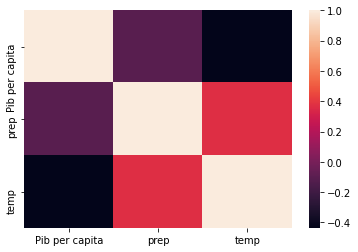

                Pib per capita      prep      temp
Pib per capita        1.000000 -0.108143 -0.435661
prep                 -0.108143  1.000000  0.367327
temp                 -0.435661  0.367327  1.000000


In [102]:
correlated_vars = country_pib_perc_df[['Pib per capita', 'prep', 'temp']]
correlated_vars['Pib per capita'] = pd.to_numeric(correlated_vars['Pib per capita'])

sns.heatmap(correlated_vars.corr())
plt.show()
print(correlated_vars.corr())

Como podemos ver la correlación de la temperatura con el pib per capita es más alta en valor absoluto que la de la precipitación. Es una variable que puede ser más influyente, aunque recordemos que correlación no indica causalidad. 

## Predicción: Regresión lineal
Vamos a realizar una regresión lineal entre las variables de temperatura y pib per capita, y otra entre las precipitaciones y el pib per capita, con el valor de los coeficientes vamos a ver si se confirma lo que intento demostrar que los países más calurosos tienden a ser más pobres.

In [103]:
import numpy as np
from sklearn import linear_model

reg = linear_model.LinearRegression()
X = country_pib_perc_df['temp']
y = country_pib_perc_df['Pib per capita']
X = np.array(X).reshape(-1, 1)
reg.fit(X, y)
y_new = reg.predict(X)
print("Coef:", reg.coef_)
print("Intercept:", reg.intercept_)

Coef: [-1111.61912223]
Intercept: 36265.33880086709


In [147]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=country_pib_perc_df['temp'], y=country_pib_perc_df['Pib per capita'],
                    mode='markers', name='countries'),)
fig.add_trace(go.Scatter(x=country_pib_perc_df['temp'], y=y_new,
                    mode='lines',
                    name='predict'))

fig.update_layout(
    xaxis_title="temperature",
    yaxis_title="PIB per cápita"
)

fig.show()

Añado esta gráfica por curiosidad, pero para la entrega utilizaré la de la temperatura

In [113]:
import numpy as np
from sklearn import linear_model

reg = linear_model.LinearRegression()
X_prep = country_pib_perc_df['prep']
y = country_pib_perc_df['Pib per capita']
X_prep = np.array(X_prep).reshape(-1, 1)
reg.fit(X_prep, y)
y_new_prep = reg.predict(X_prep)
print("Coef:", reg.coef_)
print("Intercept:", reg.intercept_)

Coef: [-3.32471055]
Intercept: 18652.852492556194


In [114]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=country_pib_perc_df['prep'], y=country_pib_perc_df['Pib per capita'],
                    mode='markers', name='countries'),)
fig.add_trace(go.Scatter(x=country_pib_perc_df['prep'], y=y_new_prep,
                    mode='lines',
                    name='predict'))

fig.show()